Duration: 6.528 s, nsamples: 313344, samplerate: 48. kHz
Shape of the result: (128, 313344)


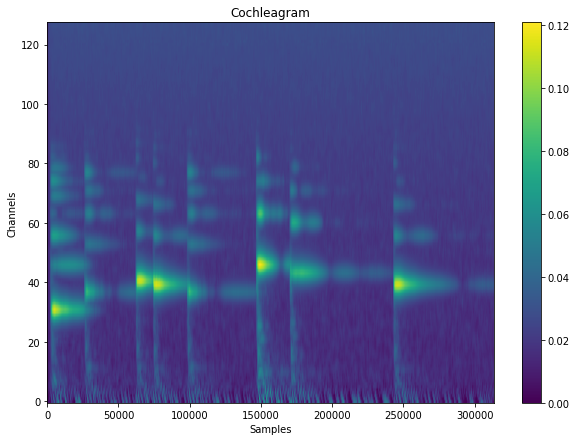

In [1]:
from os.path import join as pjoin
import numpy as np
from brian2 import *
from brian2hears import *
np.seterr(divide="ignore", invalid="ignore")

sound = Sound.load(pjoin("..", "data", "monophony", "Hedwig's Theme.wav"))
noise_rate = 0.001
sound += noise_rate * Sound.whitenoise(sound.duration, sound.samplerate, sound.nchannels)
# sound.save(pjoin("..", "data", "monophony", "Hedwig's Theme Noised.wav"))

# Processing only left channel for now...
sound = sound.left

cf = erbspace(20*Hz, 20*kHz, 128)
gammatone = Gammatone(sound, cf)
cochlea = FunctionFilterbank(gammatone, lambda x: clip(x, 0, Inf)**(1.0/3.0))
lowpass = LowPass(cochlea, 10*Hz)
output = lowpass.process().T
print(f"Duration: {sound.duration}, nsamples: {sound.nsamples}, samplerate: {sound.nsamples / sound.duration}")
print(f"Shape of the result: {output.shape}")

figure(figsize=(10, 7))
img = imshow(output, origin='lower', aspect='auto', vmin=0)
title("Cochleagram")
xlabel("Samples")
ylabel("Channels")
colorbar(img)
show()

In [2]:
import skimage
from scipy import signal

samplerate = sound.nsamples / sound.duration
window_length_s = 20 * msecond
window_length = int(window_length_s * samplerate)
window_shape = (output.shape[0], window_length)
overlap_s = 10 * msecond
overlap = int(overlap_s * samplerate)

print(f"Applying windowing to {sound.nsamples} samples:\n"""
      f"Window: {window_length_s} ({window_length} samples), shape: {window_shape}\n"
      f"Overlap: {overlap_s} ({overlap} samples)\n")

# window = signal.windows.hann(window_length)
# plot(window)
# suptitle("Hann window:")
# xlabel("Sample")
# ylabel("Amplitude")

windows = skimage.util.view_as_windows(output, window_shape, overlap).squeeze()
# windows = np.apply_along_axis(lambda vec: signal.convolve(vec, window, mode="same"), 2, windows)

print(f"Shape of the result: {windows.shape}")

Applying windowing to 313344 samples:
Window: 20. ms (960 samples), shape: (128, 960)
Overlap: 10. ms (480 samples)

Shape of the result: (651, 128, 960)


Shape of the RMS'ed windows: (128, 651)
Shape of the filtered windows: (128, 651)


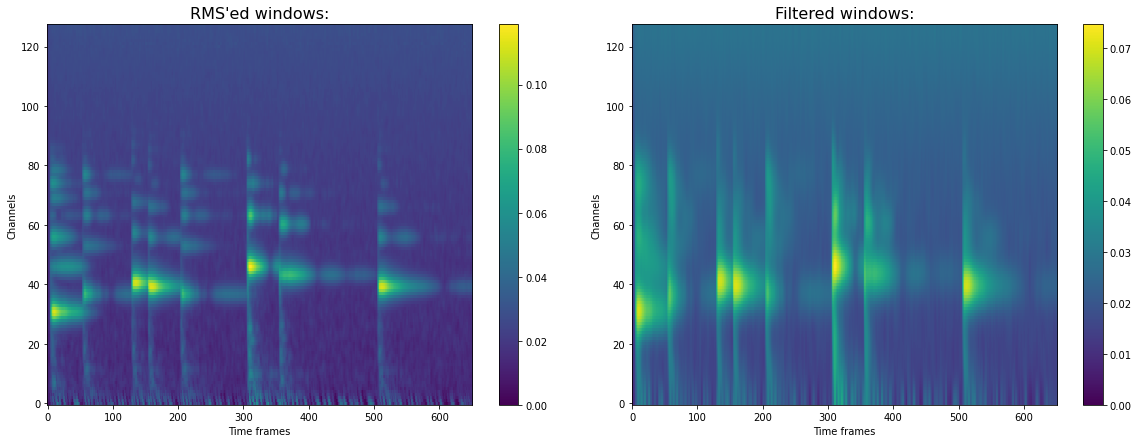

In [3]:
rmsed = np.apply_along_axis(lambda vec: np.sqrt(np.mean(np.square(vec))), 2, windows).T

print(f"Shape of the RMS'ed windows: {rmsed.shape}")
fig, (ax1, ax2) = subplots(ncols=2, figsize=(20, 7))
subplots_adjust(wspace=0.1)

img = ax1.imshow(rmsed, origin='lower', aspect='auto', vmin=0, interpolation="none")
ax1.set_title("RMS'ed windows:", fontsize=16)
ax1.set_xlabel("Time frames")
ax1.set_ylabel("Channels")
fig.colorbar(img, ax=ax1)

from scipy.ndimage import gaussian_filter
sigma = 5
filtered_gaussian = np.apply_along_axis(lambda vec: gaussian_filter(vec, sigma), 0, rmsed)

print(f"Shape of the filtered windows: {filtered_gaussian.shape}")
img = ax2.imshow(filtered_gaussian, origin='lower', aspect='auto', vmin=0, interpolation="none")
ax2.set_title("Filtered windows:", fontsize=16)
ax2.set_xlabel("Time frames")
ax2.set_ylabel("Channels")
fig.colorbar(img, ax=ax2)
show()

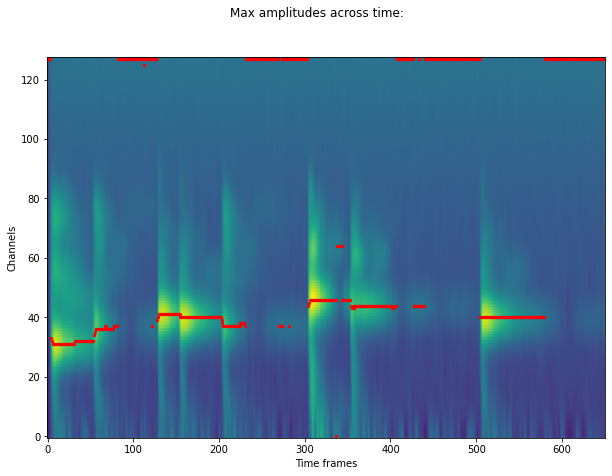

In [4]:
max_amplitudes_idxs = np.argmax(filtered_gaussian, axis=0)

figure(figsize=(10, 7))
imshow(filtered_gaussian, origin='lower', aspect='auto', vmin=0, interpolation="none")
scatter(np.arange(0, filtered_gaussian.shape[1]), max_amplitudes_idxs, s=5, c="red")

suptitle("Max amplitudes across time:")
xlabel("Time frames")
ylabel("Channels")
show()

In [5]:
fundamental_frequencies = cf[max_amplitudes_idxs]
max_amplitudes = filtered_gaussian[max_amplitudes_idxs, np.arange(filtered_gaussian.shape[1])]

print(f"Fundamental frequencies - shape {fundamental_frequencies.shape}\n"
      f"Max amplitudes - shape {max_amplitudes.shape}")

Fundamental frequencies - shape (651,)
Max amplitudes - shape (651,)


In [6]:
from statsmodels.tsa.stattools import acf
autocorr = np.apply_along_axis(lambda vec: acf(vec, nlags=vec.shape[0]), 2, windows)
print(autocorr.shape, autocorr.min(), autocorr.max())

WARNING    D:\Documents\FIT_CVUT\BAP\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
 [py.warnings]


(651, 128, 960) -0.9465554802899543 1.0


In [7]:
# Cross-channel correlation coefficients (Pearson's)
crosscorr = np.empty((autocorr.shape[0], autocorr.shape[1]))
for i, j in np.ndindex(crosscorr.shape):
      if j + 1 < autocorr.shape[1]:
            crosscorr[i, j] = np.corrcoef(autocorr[i, j], autocorr[i, j + 1])[0, 1]
print(crosscorr.shape, crosscorr.min(), crosscorr.max())

(651, 128) -3.807358636934024e-294 1.6353446135598328e+294


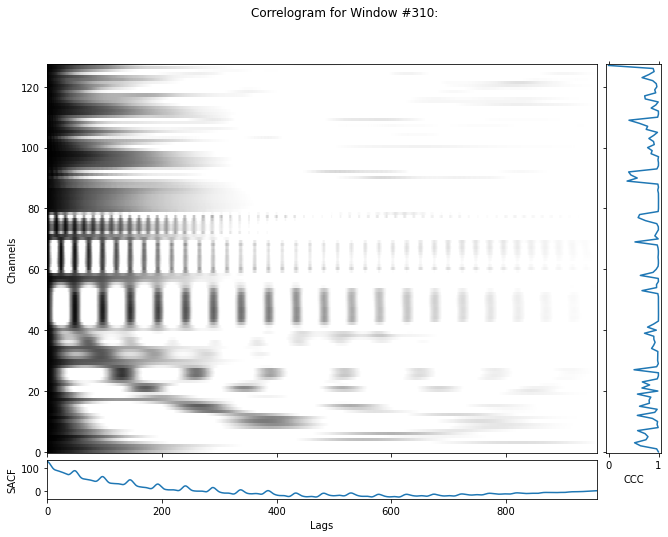

In [8]:
window_num = 310

fig, ((ax1, ax2), (ax3, ax4)) = subplots(ncols=2, nrows=2, figsize=(11, 8), sharey="row", sharex="col", gridspec_kw={"width_ratios": [10, 1],
                                                                                                                     "height_ratios": [10, 1]})
ax4.set_visible(False)
fig.suptitle(f"Correlogram for Window #{window_num}:")
subplots_adjust(wspace=0.03, hspace=0.03)

img = ax1.imshow(autocorr[window_num], origin='lower', aspect='auto', vmin=0, interpolation="none", cmap='Greys')
ax1.set_ylabel("Channels")
# fig.colorbar(img, ax=ax1)

ax2.plot(crosscorr[window_num], np.arange(autocorr.shape[1]))
ax2.set_xlabel("CCC")
ax2.tick_params(axis="x", reset=True)

ax3.plot(np.arange(autocorr.shape[2]), autocorr[window_num].sum(axis=0))
ax3.set_xlabel("Lags")
ax3.set_ylabel("SACF")

show()